# Multiview Reconstruction

If you are working in Colab,
*   Open Files from left
*   Drag and drop `Week3_MVS.zip` there (or click upload icon on top left). Upload can take a few minutes.
*   Unzip the file by running the following cell.


In [ ]:
!unzip Week3_MVS.zip
%cd Week3_MVS

*   If you get disconnected from the runtime, you might need to upload this file again. Also, note that this is valid for other local files too eg. repos that have been cloned, files generated during execution etc. In short, if you see that your files are gone after a while, just run the cell that generates, clones, etc. the missing files again.

## Part A: More on Projections

### Question 1: Transformations

Derive the matrices $M \in SE(3) \subset \mathbb{R}^{4 \times 4}$ representing the following transformations:

* Translation by the vector $T \in \mathbb{R}^3$
* Rotation by the rotation matrix $R \in \mathbb{R}^{3 \times 3}$
* Rotation by $R$ followed by the translation $T$
* Translation by $T$ followed by the rotation $R$

**Hint:** Remember that we can write the transformation matrix $M$ for a given rotation matrix
$R = \begin{bmatrix}
r_{11} & r_{12} & r_{13} \\
r_{21} & r_{22} & r_{23} \\
r_{31} & r_{32} & r_{33}
\end{bmatrix}$ and a translation vector $T = \begin{bmatrix}
t_x \\
t_y \\
t_z
\end{bmatrix}$ as follows:
$M = 
\begin{pmatrix}
R & T \\
0 & 1
\end{pmatrix}
=
\begin{bmatrix}
r_{11} & r_{12} & r_{13} & t_x \\
r_{21} & r_{22} & r_{23} & t_y \\
r_{31} & r_{32} & r_{33} & t_z \\
0 & 0 & 0 & 1 \\
\end{bmatrix}$

**Answer**: 


### Question 2: Scale Ambiguity

A classic ambiguity of the perspective projection is that one cannot tell an object from another object that is exactly twice as big but twice as far. Explain why this is true.

**Hint:** Let $P = (X, Y, Z)$ be a point on the smaller object and $P' = (X', Y', Z')$ a point on the larger object. Define $X' = 2X, Y' = 2Y, Z' = 2Z$ and perpective projection as a function $p = \pi(P)$. How does $\pi$ transform the world coordinate $P$ to image coordinate $p$ according to perspective projection? Repeat the same for $P'$ and $p'$.

**Answer**:


## Part B: Rotating Objects

Write a function that rotates the model around its center (i.e. the mean of its vertices) for given rotation angles $\alpha,~\beta,~\gamma$ around the x-, y- and z-axis. Use homogeneous coordinates and describe the overall transformation by a single matrix. 

The rotation matrices around the respective axes are as follows:

$R_x = \begin{bmatrix}
1 & 0 & 0 \\
0 & \text{cos}~\alpha & -\text{sin}~\alpha \\
0 & \text{sin}~\alpha & \text{cos}~\alpha
\end{bmatrix}
~~~%
R_y = \begin{bmatrix}
\text{cos}~\beta & 0 & \text{sin}~\beta \\
0 & 1 & 0 \\
-\text{sin}~\beta & 0 & \text{cos}~\beta
\end{bmatrix}
~~~%
R_z = \begin{bmatrix}
\text{cos}~\gamma & -\text{sin}~\gamma & 0 \\
\text{sin}~\gamma & \text{cos}~\gamma & 0 \\
0 & 0 & 1
\end{bmatrix}
$

Rotate the model first 50 degrees around the x-axis and then 25 degrees around the z-axis. Now start again by doing the same rotation around the z-axis first followed by the x-axis rotation. What do you observe?

In [1]:
import open3d as o3d
import numpy as np

def deg2rad(angleInDegrees):
    angleInRadians = (np.pi/180) * angleInDegrees
    return angleInRadians

def rotation(V, alpha_degree, beta_degree, gamma_degree):
    # Compute mean of vertices for vertex list V
    center = np.mean(V, axis=0)

    # Initialize W
    nVertices = V.shape[0]
    W = np.zeros((nVertices, 3))
    
    # Translation matrix (translates the model to the point (0,0,0))
    T = np.hstack((np.eye(3,3), np.reshape(-center, (3,1))))
    T = np.vstack((T, np.array([0,0,0,1])))
 
    # Translation back to the center of V
    T_back = np.hstack((np.eye(3,3), np.reshape(center, (3,1))))
    T_back = np.vstack((T_back, np.array([0,0,0,1])))

    # convert degrees to radians
    alpha, beta, gamma = deg2rad(alpha_degree), deg2rad(beta_degree), deg2rad(gamma_degree)
    
    # Rotation matrices in homegeneuous coordinate
    R_x = np.vstack((np.array([1, 0, 0, 0]),
                     np.array([0, np.cos(alpha), -np.sin(alpha), 0]),
                     np.array([0, np.sin(alpha), np.cos(alpha), 0]),
                     np.array([0, 0, 0, 1])))
    # print(R_x)
    
    R_y = np.vstack((np.array([np.cos(beta), 0, np.sin(beta), 0]),
                     np.array([0, 1, 0, 0]),
                     np.array([-np.sin(beta), 0, np.cos(beta), 0]),
                     np.array([0, 0, 0, 1])))
    # print(R_y)
    
    R_z = np.vstack((np.array([np.cos(gamma), -np.sin(gamma), 0, 0]),
                     np.array([np.sin(gamma), np.cos(gamma), 0, 0]),
                     np.array([0, 0, 1, 0]),
                     np.array([0, 0, 0, 1])))
    # print(R_z)

    # Overall transformation matrix
    # G = T_back * R_z * R_y * R_x * T (matrix multiplication)
    G = T_back @ R_x @ R_y @ R_z @ T
    
    print(G)

    # Homogeneous coordinates of V
    Vh = np.hstack((V, np.ones((nVertices, 1))))
    
    # Apply the transformation to the vertices
    Wh_t = G @ Vh.T
    Wh = Wh_t.T
    
    # Go back from homogenous to 3D coordinates
    W = Wh[:, :3]
    return W
         
# load the model
mesh = o3d.io.read_triangle_mesh("data/model.off")
# print(mesh)
# print('Vertices:')
V = np.asarray(mesh.vertices)
# print(V)
# print('Triangles:')
F = np.asarray(mesh.triangles)
# print(F)

# display the model
# mesh.compute_vertex_normals()
# o3d.visualization.draw_geometries([mesh])

W = rotation(V, 50, 0, 25)
rotated_mesh = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(W), triangles=mesh.triangles)

# display the rotated model
rotated_mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([rotated_mesh])

print('done!')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[[ 0.90630779 -0.42261826  0.          0.33576077]
 [ 0.27165378  0.58256342 -0.76604444  0.4805078 ]
 [ 0.32374437  0.69427204  0.64278761 -0.48216732]
 [ 0.          0.          0.          1.        ]]
done!


## Part C: pykitti

There is a nice repository which serves as a development kit for KITTI in python: [pykitti](https://github.com/utiasSTARS/pykitti)

Install it and repeat the steps below with the provided sequence to see what kind of properties of the dataset is available with pykitti. After that, you will compute stereo as you did before, this time by using pykitti.


Drive: 2011_09_26_drive_0079_sync

Frame range: range(0, 50, 5)

IMU-to-Velodyne transformation:
[[ 1.      0.0008 -0.002  -0.8087]
 [-0.0008  0.9999 -0.0148  0.3196]
 [ 0.002   0.0148  0.9999 -0.7997]
 [ 0.      0.      0.      1.    ]]

Gray stereo pair baseline [m]: 0.537150600500771

RGB stereo pair baseline [m]: 0.5327254400790535

First timestamp: 2011-09-26 14:58:03.244023

Second IMU pose:
[[ 0.9411 -0.3364  0.0338  2.9079]
 [ 0.3372  0.9413 -0.0181  1.0507]
 [-0.0257  0.0284  0.9993 -0.0247]
 [ 0.      0.      0.      1.    ]]


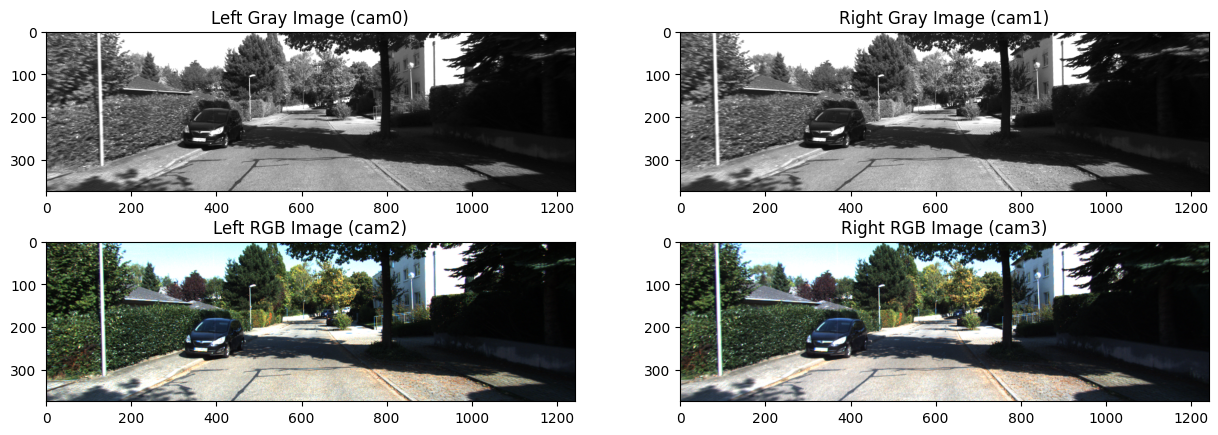

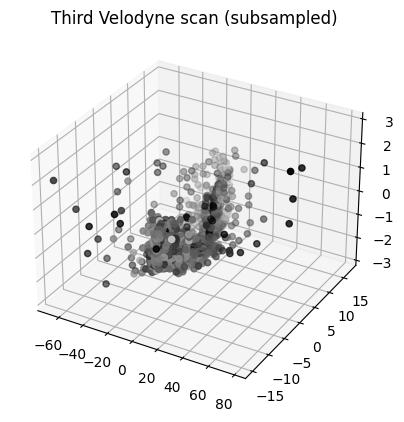

In [6]:
import pykitti
import numpy as np
from util import *

basedir = 'data/KITTI-Raw'
date = '2011_09_26'
drive = '0079'

# The 'frames' argument is optional - default: None, which loads the whole dataset.
# Calibration, timestamps, and IMU data are read automatically. 
# Camera and velodyne data are available via properties that create generators
# when accessed, or through getter methods that provide random access.
dataset = pykitti.raw(basedir, date, drive, frames=range(0, 50, 5))

# dataset.calib:         Calibration data are accessible as a named tuple
# dataset.timestamps:    Timestamps are parsed into a list of datetime objects
# dataset.oxts:          List of OXTS packets and 6-dof poses as named tuples
# dataset.camN:          Returns a generator that loads individual images from camera N
# dataset.get_camN(idx): Returns the image from camera N at idx  
# dataset.gray:          Returns a generator that loads monochrome stereo pairs (cam0, cam1)
# dataset.get_gray(idx): Returns the monochrome stereo pair at idx  
# dataset.rgb:           Returns a generator that loads RGB stereo pairs (cam2, cam3)
# dataset.get_rgb(idx):  Returns the RGB stereo pair at idx  
# dataset.velo:          Returns a generator that loads velodyne scans as [x,y,z,reflectance]
# dataset.get_velo(idx): Returns the velodyne scan at idx  

# Grab some data
second_pose = dataset.oxts[1].T_w_imu
first_gray = next(iter(dataset.gray))
first_cam1 = next(iter(dataset.cam1))
first_rgb = dataset.get_rgb(0)
first_cam2 = dataset.get_cam2(0)
third_velo = dataset.get_velo(2)

# Display some of the data
np.set_printoptions(precision=4, suppress=True)
print('\nDrive: ' + str(dataset.drive))
print('\nFrame range: ' + str(dataset.frames))

print('\nIMU-to-Velodyne transformation:\n' + str(dataset.calib.T_velo_imu))
print('\nGray stereo pair baseline [m]: ' + str(dataset.calib.b_gray))
print('\nRGB stereo pair baseline [m]: ' + str(dataset.calib.b_rgb))

print('\nFirst timestamp: ' + str(dataset.timestamps[0]))
print('\nSecond IMU pose:\n' + str(second_pose))

f, ax = plt.subplots(2, 2, figsize=(15, 5))
ax[0, 0].imshow(first_gray[0], cmap='gray')
ax[0, 0].set_title('Left Gray Image (cam0)')

ax[0, 1].imshow(first_cam1, cmap='gray')
ax[0, 1].set_title('Right Gray Image (cam1)')

ax[1, 0].imshow(first_cam2)
ax[1, 0].set_title('Left RGB Image (cam2)')

ax[1, 1].imshow(first_rgb[1])
ax[1, 1].set_title('Right RGB Image (cam3)')


f2 = plt.figure()
ax2 = f2.add_subplot(111, projection='3d')
# Plot every 100th point so things don't get too bogged down
velo_range = range(0, third_velo.shape[0], 100)
ax2.scatter(third_velo[velo_range, 0],
            third_velo[velo_range, 1],
            third_velo[velo_range, 2],
            c=third_velo[velo_range, 3],
            cmap='gray')
ax2.set_title('Third Velodyne scan (subsampled)')
plt.show()

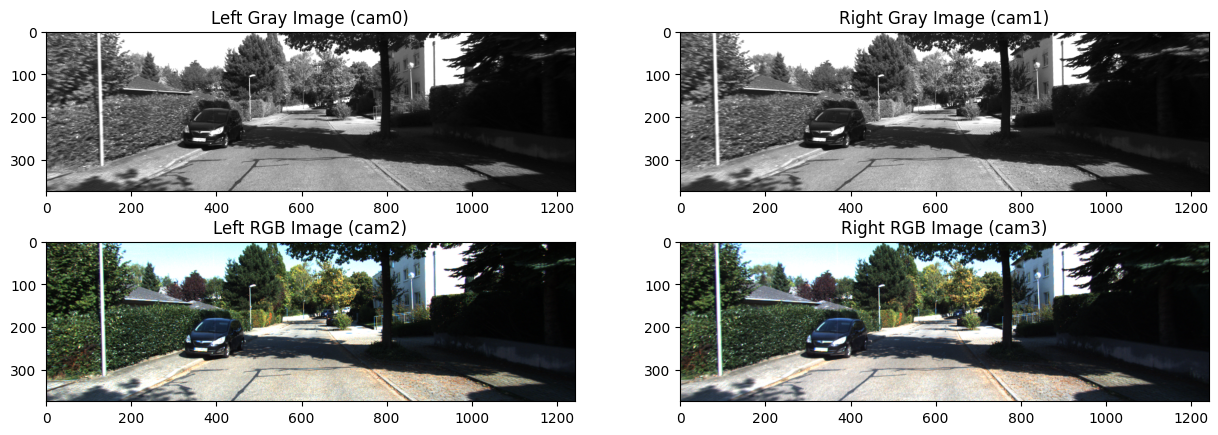

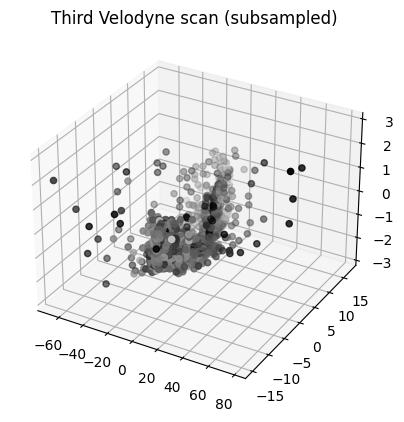

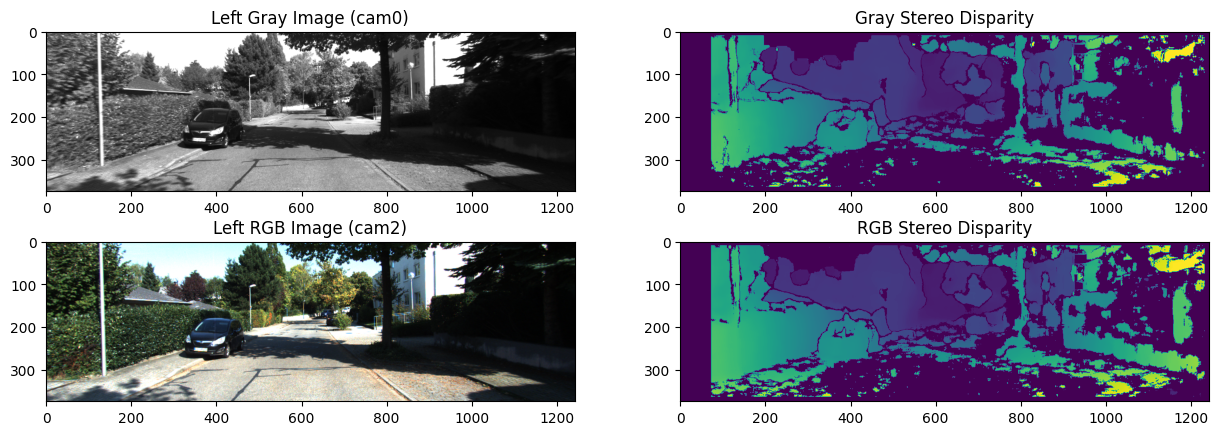

In [5]:
# Do some stereo processing
stereo = cv2.StereoBM_create()
disp_gray = stereo.compute(np.array(first_gray[0]), np.array(first_gray[1]))
disp_rgb = stereo.compute(
    cv2.cvtColor(np.array(first_rgb[0]), cv2.COLOR_RGB2GRAY),
    cv2.cvtColor(np.array(first_rgb[1]), cv2.COLOR_RGB2GRAY))

# Display some data
f, ax = plt.subplots(2, 2, figsize=(15, 5))
ax[0, 0].imshow(first_gray[0], cmap='gray')
ax[0, 0].set_title('Left Gray Image (cam0)')

ax[0, 1].imshow(disp_gray, cmap='viridis')
ax[0, 1].set_title('Gray Stereo Disparity')

ax[1, 0].imshow(first_rgb[0])
ax[1, 0].set_title('Left RGB Image (cam2)')

ax[1, 1].imshow(disp_rgb, cmap='viridis')
ax[1, 1].set_title('RGB Stereo Disparity')

plt.show()

## Part D: Terminology

### Question 4: Comparisons

1. What is the difference between *sparse* vs. *dense* methods? What is the historical reason for starting with sparse methods?
2. What is the difference between *local* vs. *global* methods? What is the historical reason for starting with local methods?

**Answer**: